### dependencies

In [5]:
import numpy as np
from numpy import concatenate
from pandas import read_csv, DataFrame, concat
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn
import sklearn
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import statsmodels
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [6]:
# # Define global variables
# #TODO find out what is the target variable and what lag steps
# num_features = 53
target_variable = 'Adj Close'
lag_steps = 1


In [19]:

df = read_csv('../../data/clean/djia_stock_data.csv',index_col=0)
df.dropna(inplace=True)
print(df.shape)
df = df.iloc[:,:31]
# isolating all the adjclose
df


(2516, 180)


,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Adj Close.4,Adj Close.5,Adj Close.6,Adj Close.7,Adj Close.8,Adj Close.9,...,Adj Close.21,Adj Close.22,Adj Close.23,Adj Close.24,Adj Close.25,Adj Close.26,Adj Close.27,Adj Close.28,Adj Close.29,Close
Price,,,,,,,,,,,,,,,,,,,,,
Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT,AAPL
2015-01-02,24.3204345703125,120.22659301757812,15.425999641418457,80.13386535644531,113.6572036743164,70.11015319824219,58.91096115112305,20.18903923034668,73.4642562866211,86.31002044677734,...,42.35361862182617,0.48314347863197327,67.8619613647461,79.6298828125,84.12157440185547,86.56096649169922,61.67287826538086,27.908205032348633,23.441490173339844,27.332500457763672
2015-01-05,23.635284423828125,118.79789733886719,15.10949993133545,78.01464080810547,112.87007141113281,66.40930938720703,57.846900939941406,19.786867141723633,70.52776336669922,85.04873657226562,...,41.67170715332031,0.4749830663204193,67.53931427001953,79.39324951171875,83.10836029052734,85.13516235351562,60.311527252197266,27.676429748535156,23.373260498046875,26.5625
2015-01-06,23.637510299682617,114.97055053710938,14.76449966430664,76.35202026367188,111.5406265258789,65.98199462890625,56.882286071777344,19.779552459716797,70.4951171875,84.59761810302734,...,41.426578521728516,0.4605824053287506,67.23164367675781,79.15354919433594,82.36640930175781,84.96338653564453,59.92290115356445,27.95575523376465,23.553373336791992,26.565000534057617
2015-01-07,23.96895980834961,118.98588562011719,14.920999526977539,78.01956176757812,113.27236938476562,67.00447845458984,56.61378860473633,19.962358474731445,70.43641662597656,85.46302032470703,...,42.28230667114258,0.45938244462013245,67.58434295654297,80.5037612915039,83.77057647705078,85.83087158203125,60.72574234008789,27.775352478027344,24.178302764892578,26.9375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,254.98965454101562,264.0,225.05999755859375,298.09912109375,177.69000244140625,364.0553894042969,342.8999938964844,58.580814361572266,142.97000122070312,111.4000015258789,...,76.76000213623047,139.6699981689453,167.09112548828125,344.8399963378906,241.36000061035156,506.3399963378906,316.6871337890625,39.24458694458008,90.3499984741211,255.27000427246094
2024-12-24,257.91644287109375,264.489990234375,229.0500030517578,302.7481994628906,179.33999633789062,366.2274169921875,344.42999267578125,59.444923400878906,143.83999633789062,112.55999755859375,...,76.79000091552734,140.22000122070312,167.9160919189453,346.5199890136719,242.8800048828125,506.1000061035156,320.1113586425781,39.107025146484375,92.68000030517578,258.20001220703125
2024-12-26,258.7355041503906,263.17999267578125,227.0500030517578,303.2769470214844,180.3800048828125,365.779052734375,341.7200012207031,59.57404327392578,143.97999572753906,112.55000305175781,...,76.94000244140625,139.92999267578125,169.1287078857422,345.510009765625,243.72999572753906,511.1499938964844,320.3709411621094,39.26424026489258,92.79000091552734,259.0199890136719


Transformation for LSTM

In [8]:
# Transform the time-series dataset specifically for LSTM
def time_series_to_lstm(df, target_variable, lag_steps=1, dropna=True, fill='ffill'):
    """
    Transforms time-series data into a supervised learning format compatible with LSTMs.
    
    Args:
        df (pd.DataFrame): The input time-series dataset.
        target_variable (str): The column to predict.
        lag_steps (int): Number of past time steps to include.
        dropna (bool): Whether to drop rows with NaN values.
        fill (str): What to fill NaN values with ('ffill', 'bfill', 'mean', 'median', None)
        
    Returns:
        df_transformed (pd.DataFrame): DataFrame to be used as input for LSTM model
    """
    # Ensure dataframe format
    if isinstance(df, list):
        df = DataFrame(df)
    
    cols = []
    feature_names = []
    
    # Create Lag Steps
    for i in range(lag_steps, 0, -1):
        cols.append(df.shift(i))
        feature_names += [f"{col}(t-{i})" for col in df.columns]
    
    # Current time step (t) for target variable
    cols.append(df[[target_variable]])
    feature_names += [f"{target_variable}(t)"]
    
    # Combine and assign column names
    df_transformed = concat(cols, axis=1)
    df_transformed.columns = feature_names

    # Drop NaN rows if required
    if dropna:
        df_transformed.dropna(inplace=True)
    else:
        if not None:
            df_transformed.fillna(method=fill, inplace=True)
    
    return df_transformed

In [36]:
newDfForApple = df[['Adj Close']]
newDfForApple = newDfForApple.drop(index = newDfForApple.index[0])
newDfForApple.index.name = 'Date'
newDfForApple

,Adj Close
Date,
2015-01-02,24.3204345703125
2015-01-05,23.635284423828125
2015-01-06,23.637510299682617
2015-01-07,23.96895980834961
2015-01-08,24.889904022216797
...,...
2024-12-23,254.98965454101562
2024-12-24,257.91644287109375
2024-12-26,258.7355041503906


In [ ]:
# lets do apple only 
df_transformed = time_series_to_lstm(newDfForApple, target_variable, lag_steps)
print(df_transformed.shape)
df_transformed.head()
# for company in companies: 
    # df_transformed.to_csv(f'data/{company}_transformed.csv')
# Export transformed dataset
df_transformed.to_csv('../../data/clean/dataset_transformed_for_LSTM.csv')
df_transformed


(2514, 2)


,Adj Close(t-1),Adj Close(t)
Price,,
2015-01-05,24.3204345703125,23.635284423828125
2015-01-06,23.635284423828125,23.637510299682617
2015-01-07,23.637510299682617,23.96895980834961
2015-01-08,23.96895980834961,24.889904022216797
2015-01-09,24.889904022216797,24.916597366333008
...,...,...
2024-12-23,254.21051025390625,254.98965454101562
2024-12-24,254.98965454101562,257.91644287109375
2024-12-26,257.91644287109375,258.7355041503906


In [32]:
# Train-Test Split
split = int(df_transformed.shape[0]*0.8)
train = df_transformed[:split]
test = df_transformed[split:]

print('Split Shape:', train.shape, test.shape)
# Scale to avoid distance calculation bias
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test) # Avoid data leakage
train.iloc[:, -1]


Split Shape: (2011, 2) (503, 2)


Price
2015-01-05    23.635284423828125
2015-01-06    23.637510299682617
2015-01-07     23.96895980834961
2015-01-08    24.889904022216797
2015-01-09    24.916597366333008
                     ...        
2022-12-21    133.89320373535156
2022-12-22    130.71022033691406
2022-12-23      130.344482421875
2022-12-27    128.53550720214844
2022-12-28    124.59138488769531
Name: Adj Close(t), Length: 2011, dtype: object

In [33]:
# Separate into features and target (last column)
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

In [34]:
# Reshape features for LSTM
X_train = X_train.reshape((X_train.shape[0], lag_steps, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], lag_steps, X_test.shape[1]))

print('Train Shape:', X_train.shape, y_train.shape)
print('Test Shape:', X_test.shape, y_test.shape)

Train Shape: (2011, 1, 1) (2011,)
Test Shape: (503, 1, 1) (503,)


## LSTM training

In [35]:
# Initiate LSTM model
model = Sequential()
model.add(LSTM(125, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

/Users/sweekiatwong/Documents/GitHub/multimodal_stockprice_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
16/16 - 1s - 83ms/step - loss: 0.2668 - val_loss: 0.9065
Epoch 2/70
16/16 - 0s - 7ms/step - loss: 0.2152 - val_loss: 0.7913
Epoch 3/70
16/16 - 0s - 7ms/step - loss: 0.1957 - val_loss: 0.7008
Epoch 4/70
16/16 - 0s - 7ms/step - loss: 0.1842 - val_loss: 0.6275
Epoch 5/70
16/16 - 0s - 7ms/step - loss: 0.1725 - val_loss: 0.5638
Epoch 6/70
16/16 - 0s - 8ms/step - loss: 0.1591 - val_loss: 0.5031
Epoch 7/70
16/16 - 0s - 7ms/step - loss: 0.1439 - val_loss: 0.4400
Epoch 8/70
16/16 - 0s - 7ms/step - loss: 0.1270 - val_loss: 0.3720
Epoch 9/70
16/16 - 0s - 7ms/step - loss: 0.1083 - val_loss: 0.2966
Epoch 10/70
16/16 - 0s - 7ms/step - loss: 0.0873 - val_loss: 0.2120
Epoch 11/70
16/16 - 0s - 7ms/step - loss: 0.0637 - val_loss: 0.1162
Epoch 12/70
16/16 - 0s - 8ms/step - loss: 0.0375 - val_loss: 0.0173
Epoch 13/70
16/16 - 0s - 8ms/step - loss: 0.0199 - val_loss: 0.0364
Epoch 14/70
16/16 - 0s - 7ms/step - loss: 0.0141 - val_loss: 0.0381
Epoch 15/70
16/16 - 0s - 7ms/step - loss: 0.0231 - val_l

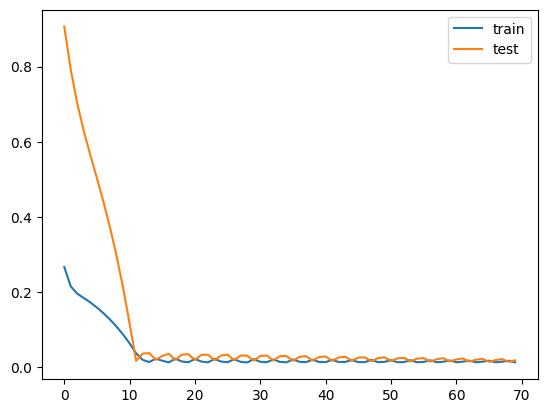

In [ ]:
# Model fitting
history = model.fit(X_train, y_train, epochs=70, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot training progression
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Predictions

### need help here not sure what this is :(

In [ ]:
# Get predicted values
yhat = model.predict(X_test)

# Reshaping back into 2D for inverse scaling
X_test_inv = X_test.reshape((X_test.shape[0], X_test.shape[2])) 

# Concatenate and Inverse Scaling
# Prediction
inv_yhat = concatenate((X_test_inv, yhat), axis=1) # Required to get back original scale
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, num_features*lag_steps] # Extract target_variable

# Validation
y_test_inv = y_test.reshape((len(y_test), 1))
inv_y = concatenate((X_test_inv, y_test_inv), axis=1) # Both arrays must have same dimensions
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, num_features*lag_steps]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


IndexError: index 53 is out of bounds for axis 1 with size 2

In [ ]:
# Get MAE
mae = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
print('LSTM Test MAE: %.3f' % mae)

In [ ]:
plt.plot(inv_y, label = 'Actual')
plt.plot(inv_yhat, label = 'Predicted')
plt.legend()
plt.show()